# fNIRS 데이터 분석/시각화

### preprocessing

모션 아티팩트 제거 :  wavelet filter 사용
bnaseline 정규화

# 

In [79]:
import mne
import os
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import pywt
import pingouin as pg
import pandas as pd

In [18]:
raw_cey = mne.io.read_raw_snirf(r'C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-30\2025-05-30_002\2025-05-30_002.snirf', preload=True)
raw_kjy = mne.io.read_raw_snirf(r'C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-29\2025-05-29_001\2025-05-29_001.snirf', preload=True)
raw_lyj = mne.io.read_raw_snirf(r'C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-30\2025-05-30_003\2025-05-30_003.snirf', preload=True)

Loading C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-30\2025-05-30_002\2025-05-30_002.snirf
Reading 0 ... 6879  =      0.000 ...   676.206 secs...
Loading C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-29\2025-05-29_001\2025-05-29_001.snirf
Reading 0 ... 8393  =      0.000 ...   825.032 secs...
Loading C:\Users\SM-PC\Desktop\research\EEG-fNIRS_face-word_stimuli\stroop-nirx\2025-05-30\2025-05-30_003\2025-05-30_003.snirf
Reading 0 ... 7299  =      0.000 ...   717.492 secs...


In [19]:
raw_lyj

<RawSNIRF | 2025-05-30_003.snirf, 40 x 7300 (717.5 s), ~2.4 MB, data loaded>

Using matplotlib as 2D backend.


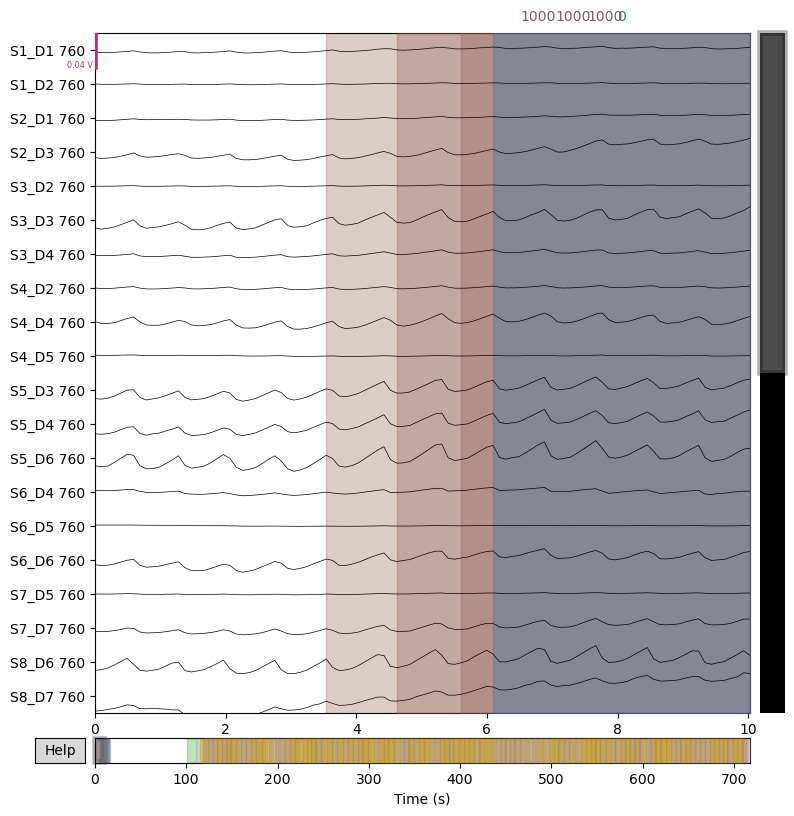

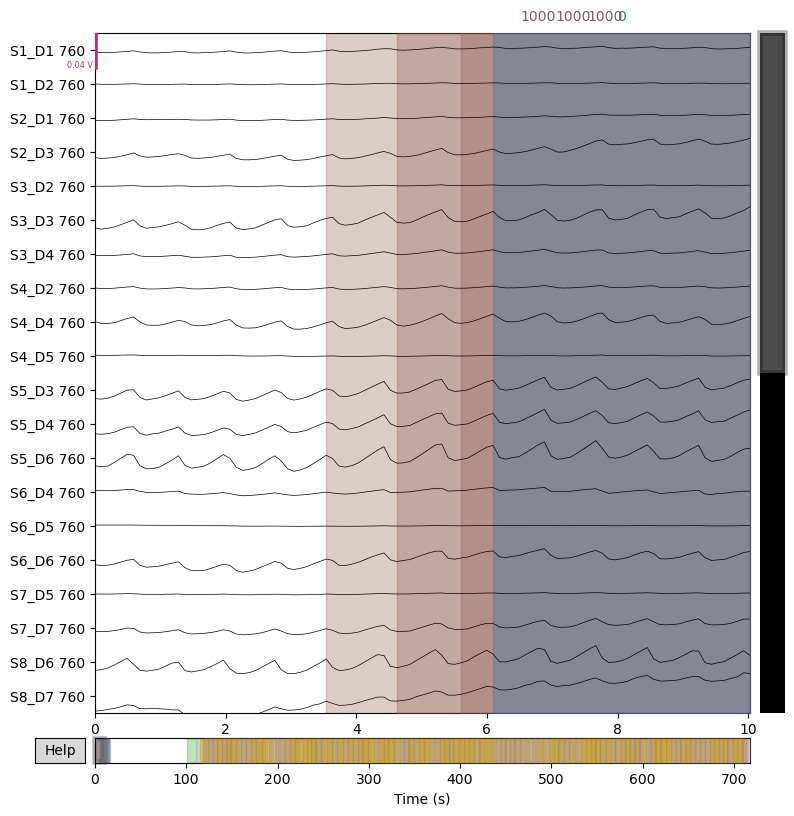

In [20]:
raw_lyj.plot()

In [4]:
raw_list = []
raw_list.append(raw_lyj)
raw_list.append(raw_cey)
raw_list.append(raw_kjy)

- Wavelet basis : 신호 분해에 사용하는 basis function  
- decomposition level : 얼마나 깊게 분해할지 결정(signal length에 따라), 보통 5~10 level
- thresholding 방식 : outlier 탐지 방법, IQR 기반(3rd quartile + 1.5*IQR), universal threshold 등
- threshold 처리 방식 : hard/soft, 대부분 hard
- channel by channel

In [6]:
def wavelet_denoise(signal, wavelet='db4', level=5, threshold_multiplier=1.5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []

    for c in coeffs:
        thresh = np.median(np.abs(c)) / 0.6745 * threshold_multiplier
        c_filtered = pywt.threshold(c, thresh, mode='hard')
        new_coeffs.append(c_filtered)
    
    return pywt.waverec(new_coeffs, wavelet)

In [71]:
signal = raw_lyj.get_data()
wavelet_signal = np.array(wavelet_denoise(signal))

raw_lyj._data = wavelet_signal

In [72]:
signal = raw_cey.get_data()
wavelet_signal = np.array(wavelet_denoise(signal))

raw_cey._data = wavelet_signal

In [73]:
signal = raw_kjy.get_data()
wavelet_signal = np.array(wavelet_denoise(signal))

raw_kjy._data = wavelet_signal

In [53]:
import mne

def apply_mbll(raw, dpf=6.26, convert_to_mm=True):
    """
    Apply Modified Beer-Lambert Law (MBLL) to fNIRS raw data.

    Parameters:
    ----------
    raw : mne.io.Raw
        Raw fNIRS data loaded with preload=True, must be in amplitude (nirs_cw_amplitude) form.
    dpf : float
        Differential pathlength factor. Default is 6.26 (adult average).
    convert_to_mm : bool
        Whether to convert source-detector distance units to mm (required for MBLL). Default True.

    Returns:
    -------
    raw_hb : mne.io.Raw
        Raw object with MBLL applied (HbO and HbR data).
    """

    # Step 1: Convert to optical density
    raw_od = mne.preprocessing.nirs.optical_density(raw)

    # Step 2: Apply Beer-Lambert Law (MBLL)
    raw_hb = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=dpf)

    return raw_hb


In [74]:
mbll_lyj = apply_mbll(raw_lyj)
mbll_kjy = apply_mbll(raw_kjy)
mbll_cey = apply_mbll(raw_cey)

C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\988010049.py:23: RuntimeWarning:

Negative intensities encountered. Setting to abs(x)

C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\988010049.py:23: RuntimeWarning:

Negative intensities encountered. Setting to abs(x)

C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\988010049.py:23: RuntimeWarning:

Negative intensities encountered. Setting to abs(x)



In [76]:
import pandas as pd
def extract_epoch_hbo_means(raw_hb, subject_id, tmin=0.0, tmax=10.0):
    """
    한 subject의 MBLL된 raw_hb에서 event_code 기준으로 epoch 분할 후
    HbO 평균값 추출
    """
    events, _ = mne.events_from_annotations(raw_hb)
    event_id = {'30': 7}
    
    epochs = mne.Epochs(raw_hb, events, event_id=event_id, tmin=tmin, tmax=tmax,
                        baseline=(0, 1), preload=True)

    hbo_chs = [ch for ch in epochs.ch_names if 'hbo' in ch]

    data = []
    for i, epoch in enumerate(epochs.get_data()):  # shape: (n_epochs, n_channels, n_times)
        for ch_idx, ch_name in enumerate(epochs.ch_names):
            if ch_name in hbo_chs:
                hbo_mean = epoch[ch_idx].mean()
                data.append({
                    'subject': subject_id,
                    'trial': i + 1,
                    'channel': ch_name,
                    'hbo_mean': hbo_mean
                })

    return pd.DataFrame(data)


In [77]:
df_all = pd.concat([
    extract_epoch_hbo_means(mbll_lyj, subject_id='S1'),
    extract_epoch_hbo_means(mbll_cey, subject_id='S2'),
    extract_epoch_hbo_means(mbll_kjy, subject_id='S3')
], ignore_index=True)


Used Annotations descriptions: ['0', '1', '10', '100', '1000', '2', '30', '50']
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 107 events and 103 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['0', '1', '10', '100', '1000', '2', '30', '50']
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 107 events and 103 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['0', '1', '10', '100', '1000', '2', '30', '50']
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 107 events and 103 original time points ...
0 bad epochs dropped


C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\1120358799.py:16: FutureWarning:

The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning

C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\1120358799.py:16: FutureWarning:

The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning

C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\1120358799.py:16: FutureWarning:

The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning



In [86]:
channel_names = mbll_cey.ch_names


In [87]:
channel_names

['S1_D1 hbo',
 'S1_D2 hbo',
 'S2_D1 hbo',
 'S2_D3 hbo',
 'S3_D2 hbo',
 'S3_D3 hbo',
 'S3_D4 hbo',
 'S4_D2 hbo',
 'S4_D4 hbo',
 'S4_D5 hbo',
 'S5_D3 hbo',
 'S5_D4 hbo',
 'S5_D6 hbo',
 'S6_D4 hbo',
 'S6_D5 hbo',
 'S6_D6 hbo',
 'S7_D5 hbo',
 'S7_D7 hbo',
 'S8_D6 hbo',
 'S8_D7 hbo',
 'S1_D1 hbr',
 'S1_D2 hbr',
 'S2_D1 hbr',
 'S2_D3 hbr',
 'S3_D2 hbr',
 'S3_D3 hbr',
 'S3_D4 hbr',
 'S4_D2 hbr',
 'S4_D4 hbr',
 'S4_D5 hbr',
 'S5_D3 hbr',
 'S5_D4 hbr',
 'S5_D6 hbr',
 'S6_D4 hbr',
 'S6_D5 hbr',
 'S6_D6 hbr',
 'S7_D5 hbr',
 'S7_D7 hbr',
 'S8_D6 hbr',
 'S8_D7 hbr']

In [100]:
df_ch = df_all[df_all['channel'] == channel_names[1]]  

anova = pg.rm_anova(
    data=df_ch,
    dv='hbo_mean',
    within='trial',
    subject='subject',
    detailed=True
)
print(anova)


  Source            SS   DF            MS         F     p-unc  p-GG-corr  \
0  trial  3.280675e-07  106  3.094976e-09  1.147205  0.200558   0.402146   
1  Error  5.719424e-07  212  2.697841e-09       NaN       NaN        NaN   

        ng2       eps sphericity  W-spher  p-spher  
0  0.362408  0.014601      False      inf      0.0  
1       NaN       NaN        NaN      NaN      NaN  


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars



In [101]:
df_roi = (
    df_all.groupby(['subject', 'trial'])
    .agg({'hbo_mean': 'mean'})
    .reset_index()
)

anova = pg.rm_anova(
    data=df_roi,
    dv='hbo_mean',
    within='trial',
    subject='subject',
    detailed=True
)


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars



C:\Users\SM-PC\AppData\Local\Temp\ipykernel_182288\1585053197.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning:

All-NaN axis encountered

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning:

All-NaN axis encountered

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning:

All-NaN axis encountered

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning:

All-NaN axis encountered

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning:

All-NaN axis encountered

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning:

All-NaN axis encountered



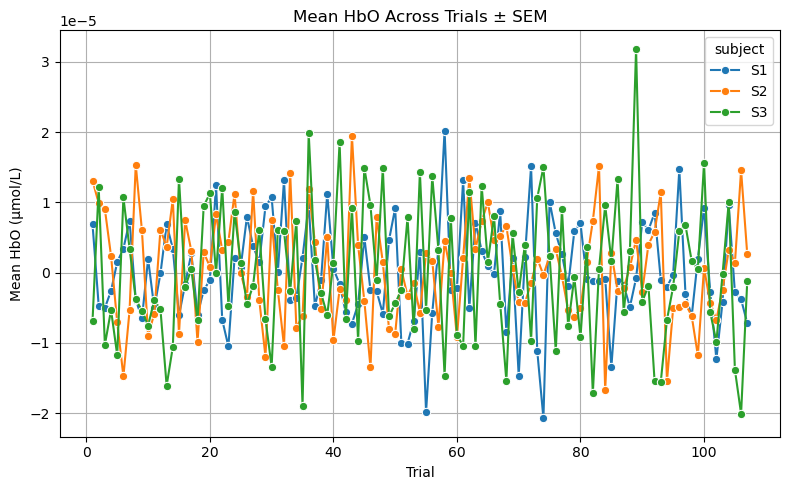

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

# Trial별 평균과 표준오차(SEM)를 계산하고 시각화
sns.lineplot(
    data=df_roi,
    x='trial',
    y='hbo_mean',
    hue='subject',
    marker='o',
    err_style='bars',
    ci='sd'
)


plt.title('Mean HbO Across Trials ± SEM')
plt.xlabel('Trial')
plt.ylabel('Mean HbO (μmol/L)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [103]:
import pingouin as pg

anova = pg.rm_anova(
    data=df_roi,
    dv='hbo_mean',
    within='trial',
    subject='subject',
    detailed=True
)

print(anova)


  Source            SS   DF            MS         F     p-unc  p-GG-corr  \
0  trial  6.036983e-09  106  5.695267e-11  0.774233  0.930132   0.515886   
1  Error  1.559475e-08  212  7.356013e-11       NaN       NaN        NaN   

        ng2      eps sphericity  W-spher  p-spher  
0  0.278935  0.01788      False      inf      0.0  
1       NaN      NaN        NaN      NaN      NaN  


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars



In [104]:
import statsmodels.formula.api as smf

model = smf.ols('hbo_mean ~ trial', data=df_roi).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               hbo_mean   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6488
Date:                Thu, 05 Jun 2025   Prob (F-statistic):              0.421
Time:                        12:37:12   Log-Likelihood:                 3303.8
No. Observations:                 321   AIC:                            -6604.
Df Residuals:                     319   BIC:                            -6596.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.425e-07   9.25e-07      0.911      0.3

In [110]:
df_roi['trial_group'] = ((df_roi['trial'] - 1) // 10 + 1).astype(int)


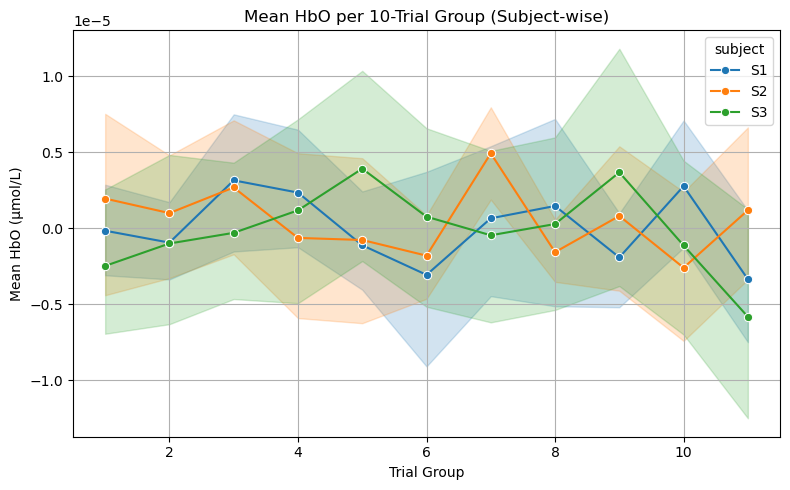

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_roi, x='trial_group', y='hbo_mean', hue='subject', marker='o')
plt.title('Mean HbO per 10-Trial Group (Subject-wise)')
plt.xlabel('Trial Group')
plt.ylabel('Mean HbO (μmol/L)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
import pingouin as pg

anova_grouped = pg.rm_anova(
    data=df_roi,
    dv='hbo_mean',
    within='trial_group',
    subject='subject',
    detailed=True
)

print(anova_grouped)


        Source            SS  DF            MS         F     p-unc  p-GG-corr  \
0  trial_group  5.259332e-11  10  5.259332e-12  0.859848  0.582034   0.485706   
1        Error  1.223316e-10  20  6.116580e-12       NaN       NaN        NaN   

        ng2       eps sphericity  W-spher  p-spher  
0  0.296903  0.187896      False      inf      0.0  
1       NaN       NaN        NaN      NaN      NaN  


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars



In [107]:
import pingouin as pg

# 결과 저장용 리스트
results = []

# 채널별 반복
for ch in df_all['channel'].unique():
    df_ch = df_all[df_all['channel'] == ch]
    
    # trial 기준 반복측정 ANOVA
    try:
        aov = pg.rm_anova(
            data=df_ch,
            dv='hbo_mean',
            within='trial',
            subject='subject',
            detailed=True
        )
        aov['channel'] = ch
        results.append(aov)
    except Exception as e:
        print(f"ANOVA failed for channel {ch}: {e}")


c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning:

divide by zero encountered in double_scalars

c:\Users\SM-PC\anaconda3\envs\python3.8\lib\site-packages\pingouin\distribution.py:1004:

In [108]:
df_anova_results = pd.concat(results, ignore_index=True)


In [109]:
df_anova_results

Source            SS   DF            MS         F     p-unc  p-GG-corr  \
0   trial  5.758581e-08  106  5.432624e-10  1.235229  0.099191   0.383184   
1   Error  9.323909e-08  212  4.398070e-10       NaN       NaN        NaN   
2   trial  3.280675e-07  106  3.094976e-09  1.147205  0.200558   0.402146   
3   Error  5.719424e-07  212  2.697841e-09       NaN       NaN        NaN   
4   trial  1.703452e-07  106  1.607030e-09  1.048894  0.381047   0.423392   
5   Error  3.248092e-07  212  1.532119e-09       NaN       NaN        NaN   
6   trial  8.605219e-09  106  8.118131e-11  0.995582  0.503016   0.424891   
7   Error  1.728681e-08  212  8.154158e-11       NaN       NaN        NaN   
8   trial  8.524626e-08  106  8.042100e-10  1.002612  0.486360   0.422211   
9   Error  1.700483e-07  212  8.021146e-10       NaN       NaN        NaN   
10  trial  1.019163e-09  106  9.614748e-12  1.002778  0.485970   0.422181   
11  Error  2.032680e-09  212  9.588116e-12       NaN       NaN        NaN   
12  trial  9.529715e-08  106  8.990297e-10  1.205406  0.127514   0.389674   
13  Error  1.581162e-07  212  7.458312e-10       NaN       NaN        NaN   
14  trial  2.694629e-07  106  2.542103e-09  0.914678  0.694219   0.466903   
15  Error  5.891971e-07  212  2.779232e-09       NaN       NaN        NaN   
16  trial  8.368870e-08  106  7.895160e-10  1.033344  0.415386   0.416553   
17  Error  1.619764e-07  212  7.640396e-10       NaN       NaN        NaN   
18  trial  4.651057e-07  106  4.387789e-09  1.122573  0.239125   0.410054   
19  Error  8.286420e-07  212  3.908689e-09       NaN       NaN        NaN   
20  trial  5.466616e-09  106  5.157185e-11  0.984972  0.528328   0.434057   
21  Error  1.110004e-08  212  5.235867e-11       NaN       NaN        NaN   
22  trial  5.074421e-08  106  4.787190e-10  0.893189  0.741275   0.466184   
23  Error  1.136248e-07  212  5.359659e-10       NaN       NaN        NaN   
24  trial  2.143909e-09  106  2.022556e-11  0.903593  0.718843   0.473717   
25  Error  4.745298e-09  212  2.238348e-11       NaN       NaN        NaN   
26  trial  6.293789e-08  106  5.937536e-10  1.036163  0.409071   0.431072   
27  Error  1.214826e-07  212  5.730312e-10       NaN       NaN        NaN   
28  trial  4.571311e-08  106  4.312557e-10  0.889107  0.749876   0.466122   
29  Error  1.028292e-07  212  4.850436e-10       NaN       NaN        NaN   
30  trial  5.417405e-09  106  5.110760e-11  0.980975  0.537904   0.434227   
31  Error  1.104494e-08  212  5.209876e-11       NaN       NaN        NaN   
32  trial  2.482745e-07  106  2.342212e-09  0.965747  0.574451   0.450302   
33  Error  5.141606e-07  212  2.425286e-09       NaN       NaN        NaN   
34  trial  1.678699e-08  106  1.583678e-10  1.123400  0.237755   0.401960   
35  Error  2.988604e-08  212  1.409719e-10       NaN       NaN        NaN   
36  trial  1.502998e-09  106  1.417923e-11  0.898413  0.730101   0.462747   
37  Error  3.345896e-09  212  1.578253e-11       NaN       NaN        NaN   
38  trial  1.826338e-08  106  1.722961e-10  0.851758  0.822420   0.461708   
39  Error  4.288399e-08  212  2.022830e-10       NaN       NaN        NaN   

         ng2       eps sphericity  W-spher  p-spher    channel  
0   0.371496  0.011233      False      inf      0.0  S1_D1 hbo  
1        NaN       NaN        NaN      NaN      NaN  S1_D1 hbo  
2   0.362408  0.014601      False      inf      0.0  S1_D2 hbo  
3        NaN       NaN        NaN      NaN      NaN  S1_D2 hbo  
4   0.343914  0.013731      False      inf      0.0  S2_D1 hbo  
5        NaN       NaN        NaN      NaN      NaN  S2_D1 hbo  
6   0.332031  0.009815      False      inf      0.0  S2_D3 hbo  
7        NaN       NaN        NaN      NaN      NaN  S2_D3 hbo  
8   0.333846  0.009451      False      inf      0.0  S3_D2 hbo  
9        NaN       NaN        NaN      NaN      NaN  S3_D2 hbo  
10  0.333813  0.009452      False      inf      0.0  S3_D3 hbo  
11       NaN       NaN        NaN      NaN      NaN  S3_D3 hbo  


In [111]:
significant_channels = df_anova_results[
    (df_anova_results['Source'] == 'trial') &
    (df_anova_results['p-unc'].notna()) &
    (df_anova_results['p-unc'] < 0.05)
]

# 필요한 열만 보기 좋게 정리 (선택사항)
significant_channels = significant_channels[['channel', 'p-unc', 'F', 'ng2']]

# 결과 출력
print(significant_channels)

Empty DataFrame
Columns: [channel, p-unc, F, ng2]
Index: []


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# trial_group 열 생성 (예: trial 1~10 → 1, 11~20 → 2, ...)
df_anova_results['trial_group'] = ((df_anova_results['trial'] - 1) // 10 + 1).astype(int)

# 평균 및 표준오차 계산
summary = (
    df_anova_results.groupby(['channel', 'trial_group'])
    .agg(mean_hbo=('hbo_mean', 'mean'),
         sem_hbo=('hbo_mean', lambda x: x.std(ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# 채널별로 그래프 시각화
channels = summary['channel'].unique()

for ch in channels:
    ch_data = summary[summary['channel'] == ch]
    
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        ch_data['trial_group'],
        ch_data['mean_hbo'],
        yerr=ch_data['sem_hbo'],
        fmt='-o',
        capsize=5,
        label=f'{ch}'
    )
    
    plt.title(f'Channel: {ch} — Mean HbO ± SEM per Trial Group')
    plt.xlabel('Trial Group (10 trials per group)')
    plt.ylabel('Mean HbO')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


KeyError: 'trial'

In [117]:
events, event_id = mne.events_from_annotations(mbll_cey)

Used Annotations descriptions: ['0', '1', '10', '100', '1000', '2', '30', '50']


In [121]:
import mne

# 예시: raw 객체와 events가 이미 존재할 경우
# events: (n_events, 3) array (sample 번호, 0, 이벤트 코드)
# event_id: {'condition1': 1, 'condition2': 2} 형태

event_id = dict()
for ev_code in np.unique(events[:, 2]):
    event_id[f"event_{ev_code}"] = int(ev_code)

# Epoch 생성
epochs = mne.Epochs(
    mbll_cey,                  # Raw 객체
    events,               # 이벤트 배열
    event_id=event_id,    # 이벤트 딕셔너리
    tmin= -1.0,            # 자극 이전 1000ms
    tmax= 1.0,             # 자극 이후 5000ms
    baseline=(None, 0),   # 베이스라인 보정
    preload=True,          # 메모리에 로드
    event_repeated='drop'  # 중복 이벤트 무시
)


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
253 matching events found
Setting baseline interval to [-0.9829999999999999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 21 original time points ...
0 bad epochs dropped


combining channels using "mean"
combining channels using "mean"


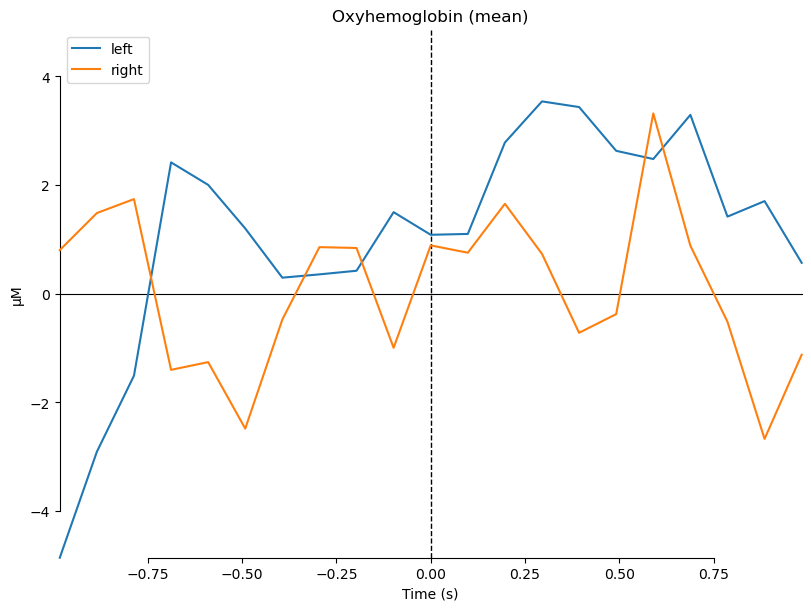

[<Figure size 800x600 with 1 Axes>]

In [123]:
import mne

# event_id가 1과 2인 경우 각각 epoch 선택
epochs_event1 = epochs['event_2'] #왼쪽
epochs_event2 = epochs['event_6'] #오른쪽

# 평균 파형(Evoked 객체) 생성
evoked_event1 = epochs_event1.average()
evoked_event2 = epochs_event2.average()

# 시각화
mne.viz.plot_compare_evokeds(
    {'left': evoked_event1, 'right': evoked_event2},
    picks='hbo',  # 또는 'hbr' 등 원하는 채널 타입
    combine='mean'  # 여러 채널 평균
)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


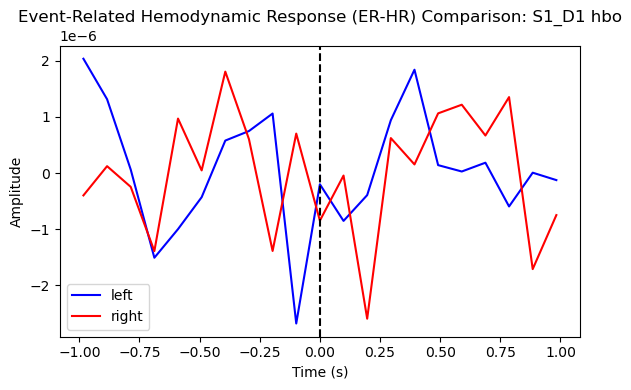

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


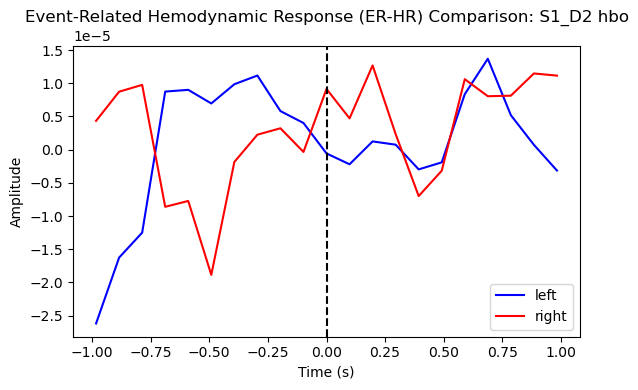

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


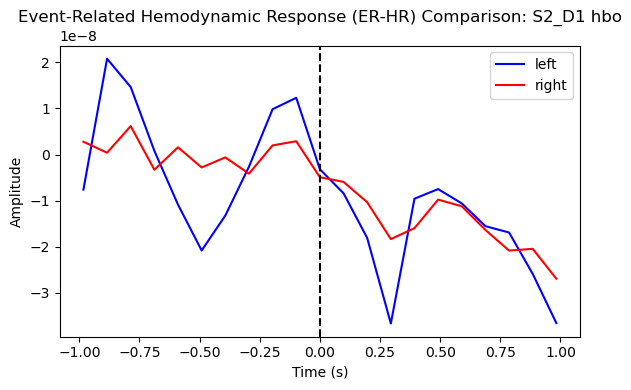

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


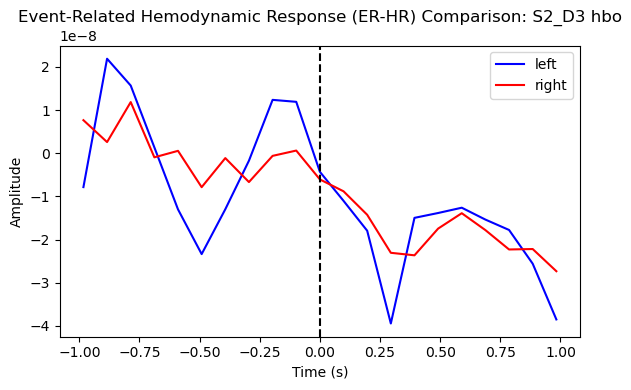

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


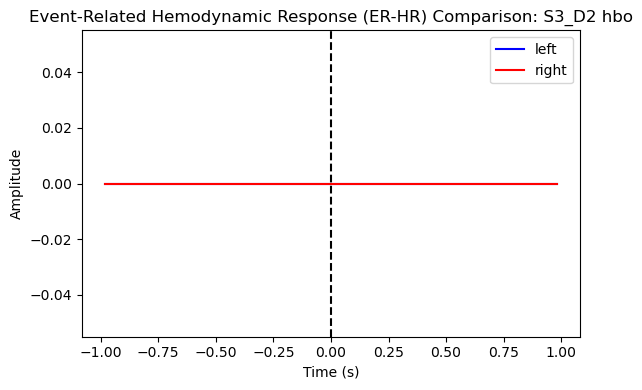

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


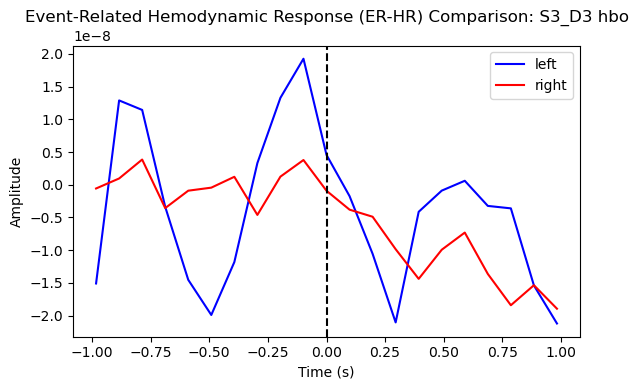

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


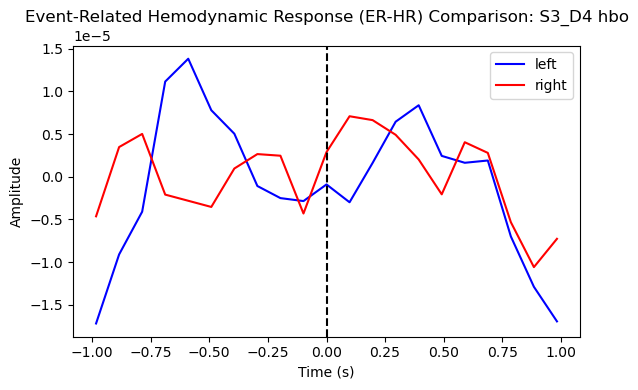

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


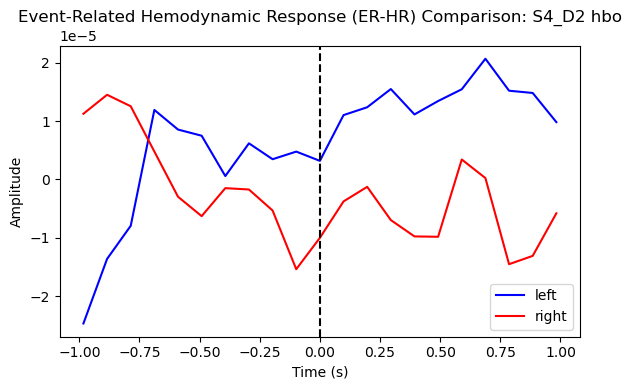

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


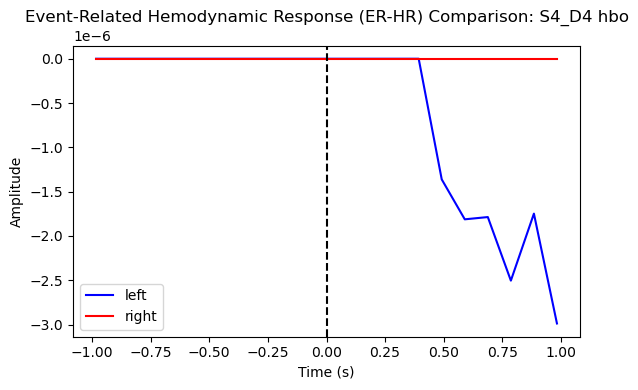

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


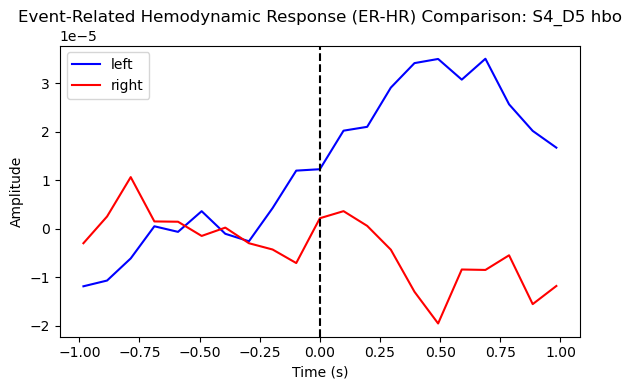

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


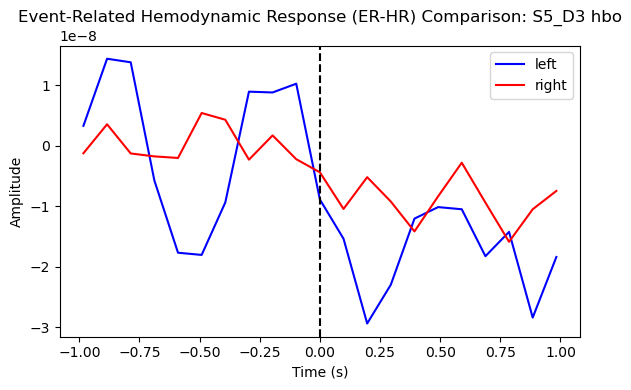

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


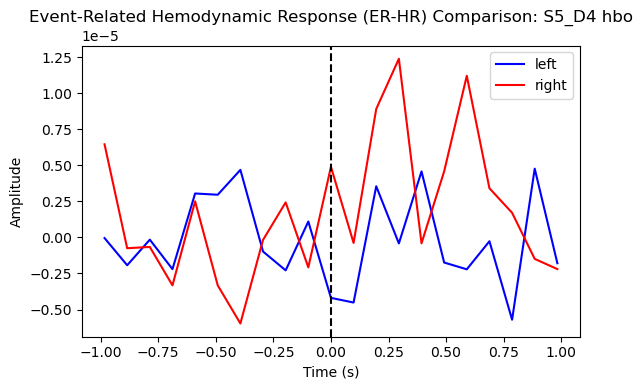

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


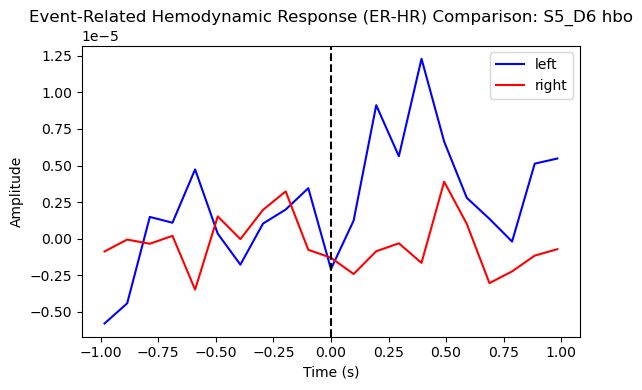

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


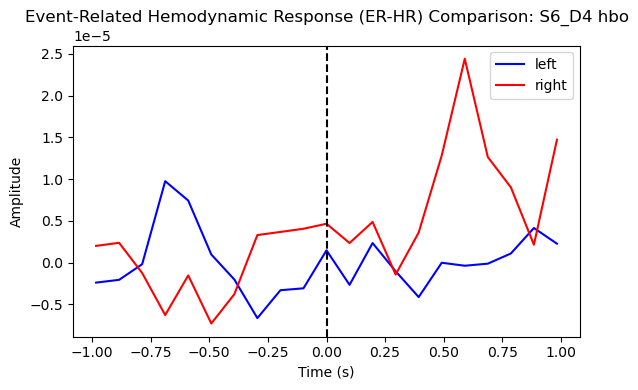

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


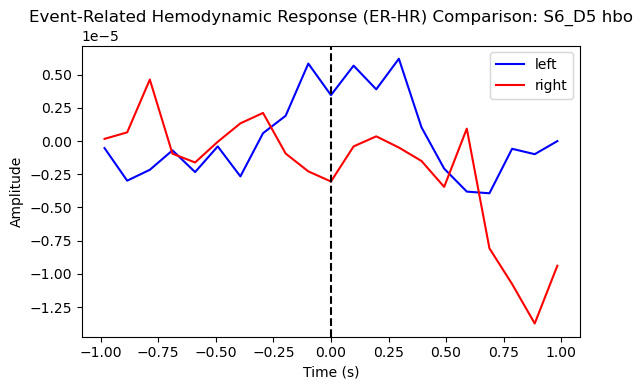

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


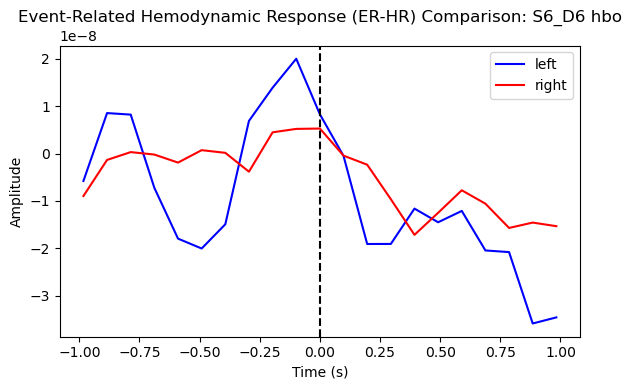

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


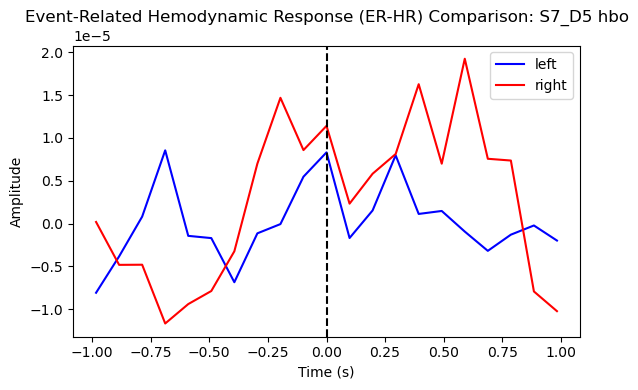

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


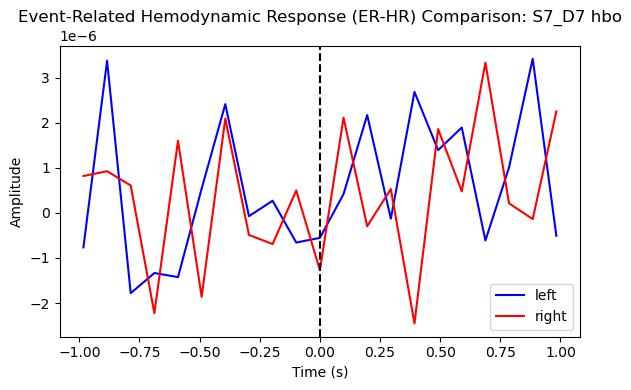

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


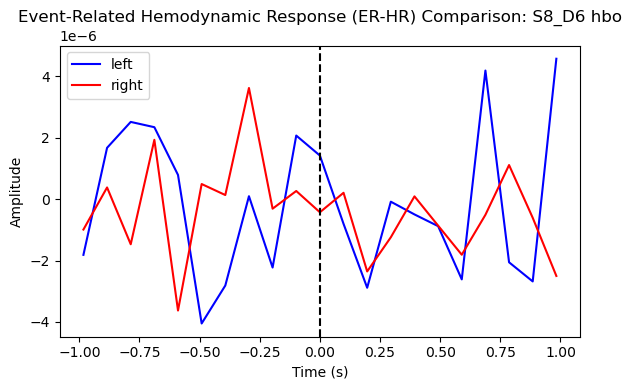

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


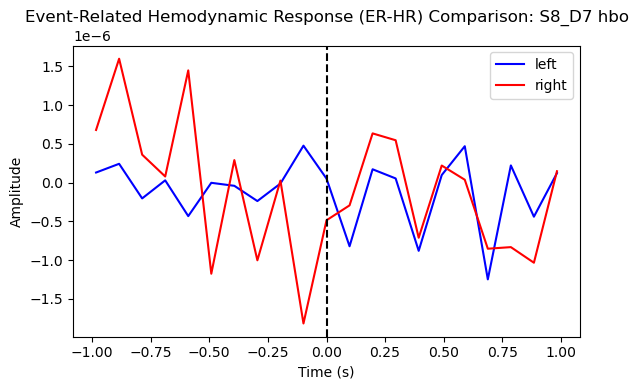

In [125]:
import mne
import matplotlib.pyplot as plt


# 채널 리스트 추출 (예: hbo 채널만)
channel_names = [ch for ch in epochs.ch_names if 'hbo' in ch]

# 채널별로 plot
for ch in channel_names:
    evoked1 = epochs_event1.copy().pick_channels([ch]).average()
    evoked2 = epochs_event2.copy().pick_channels([ch]).average()

    # Plot
    plt.figure(figsize=(6, 4))
    plt.title(f'Event-Related Hemodynamic Response (ER-HR) Comparison: {ch}')
    plt.plot(evoked1.times, evoked1.data[0], label='left', color='blue')
    plt.plot(evoked2.times, evoked2.data[0], label='right', color='red')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()


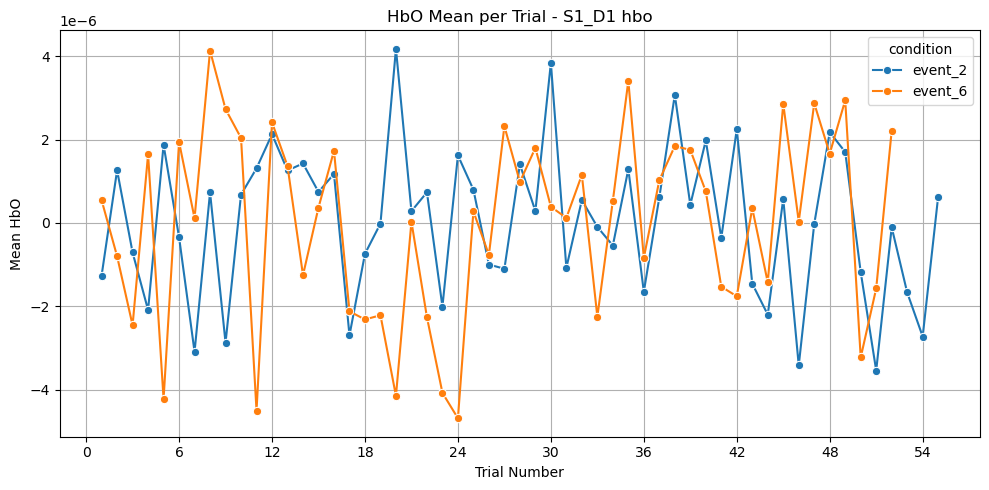

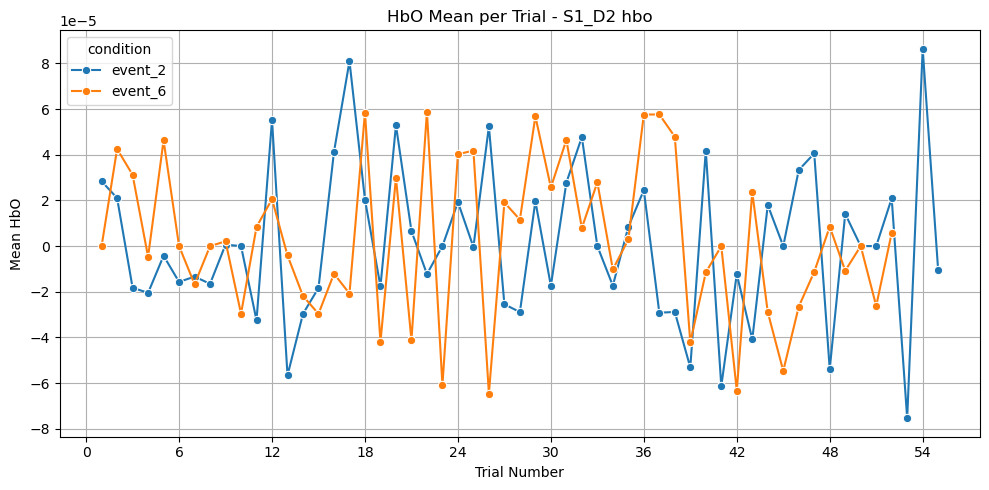

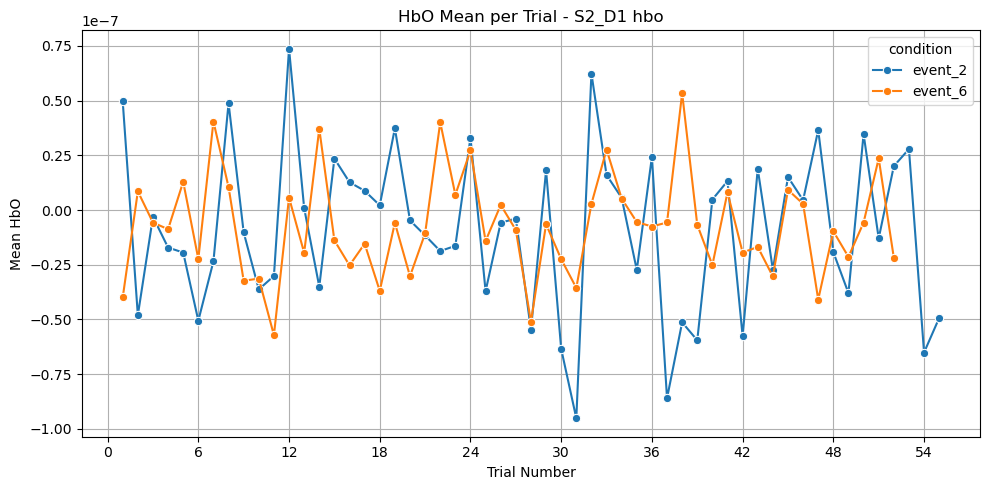

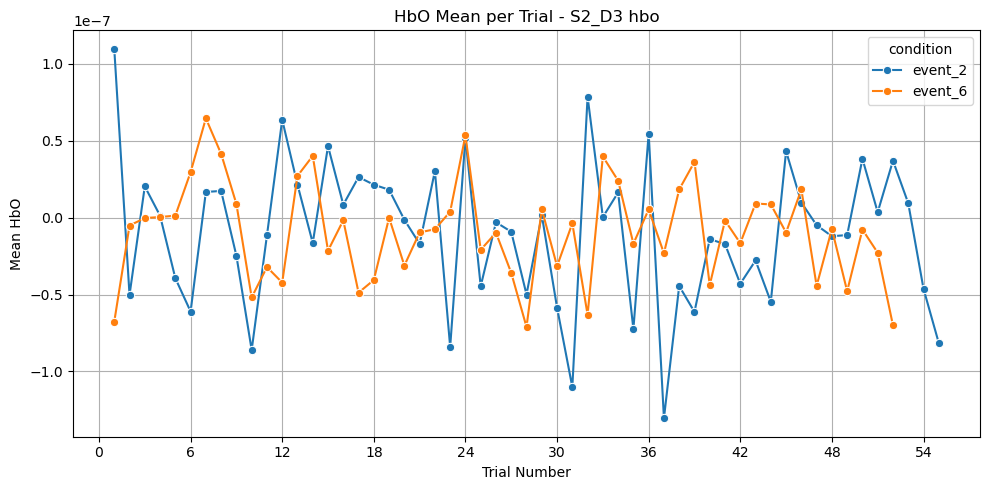

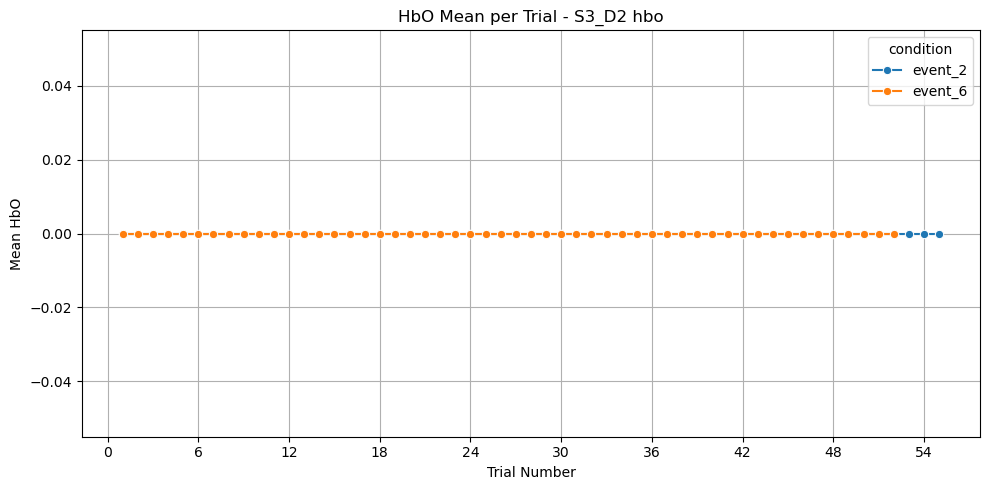

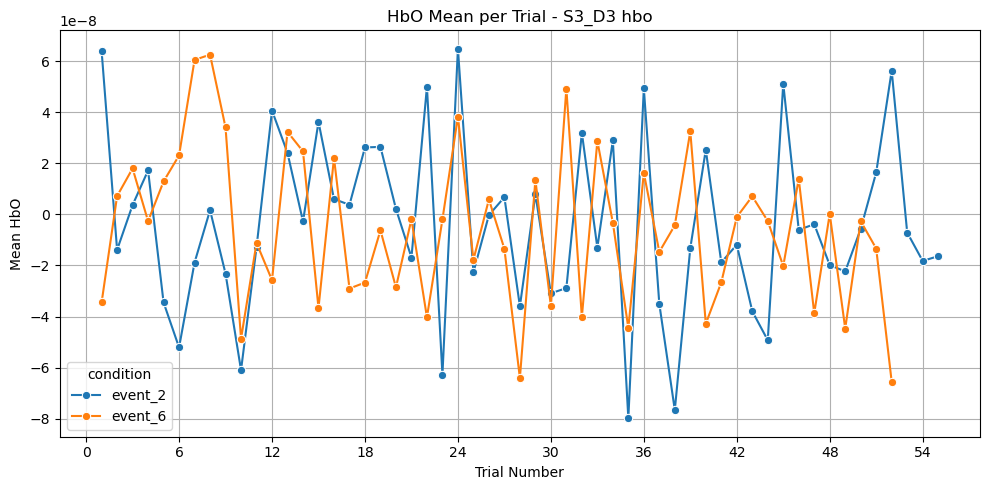

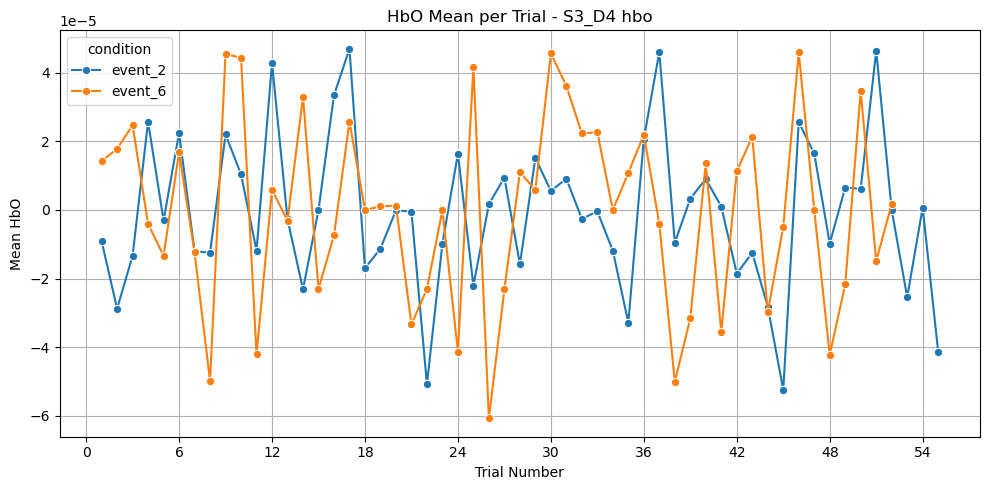

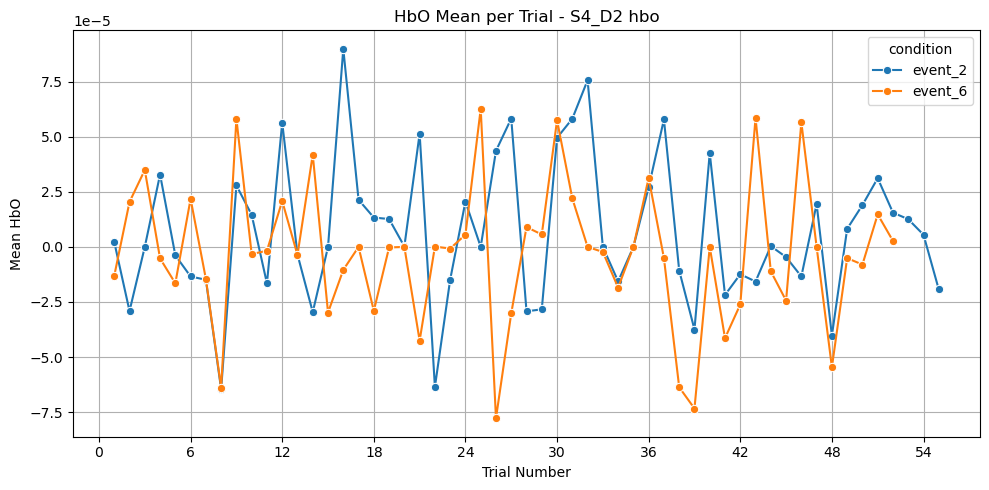

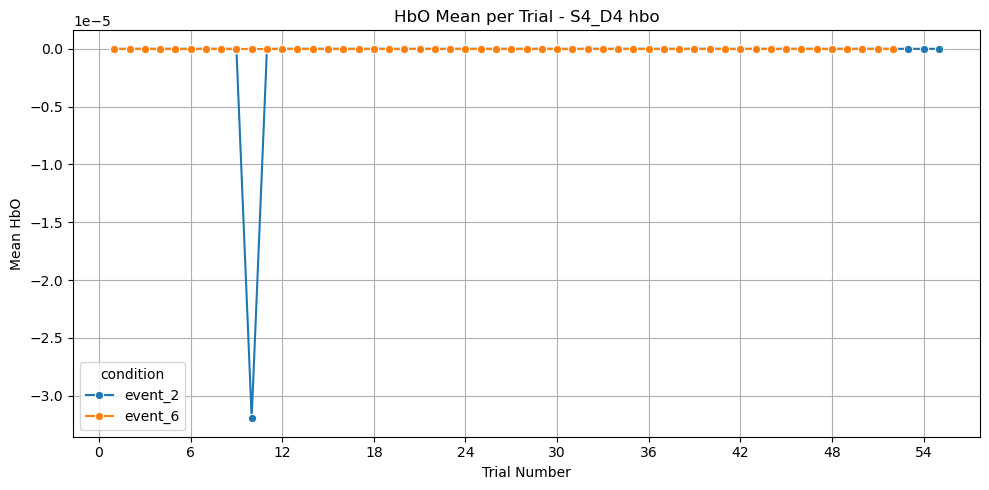

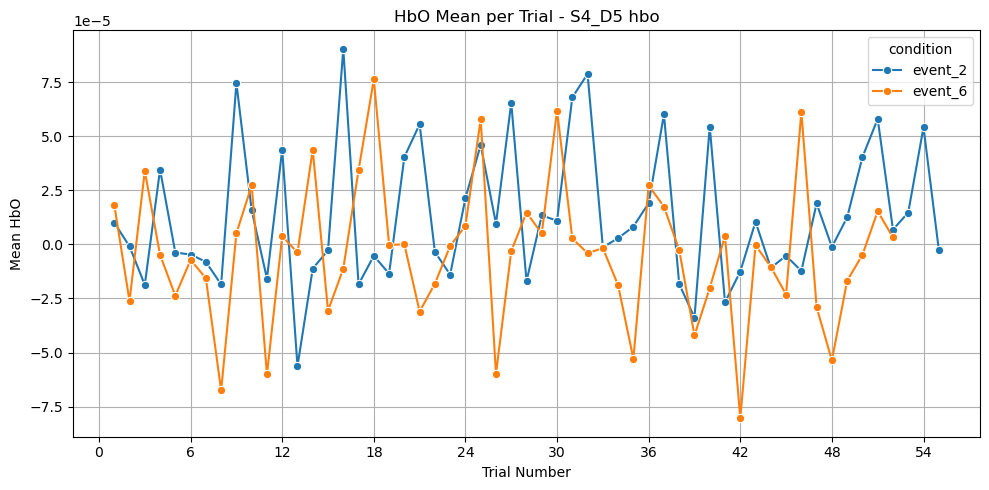

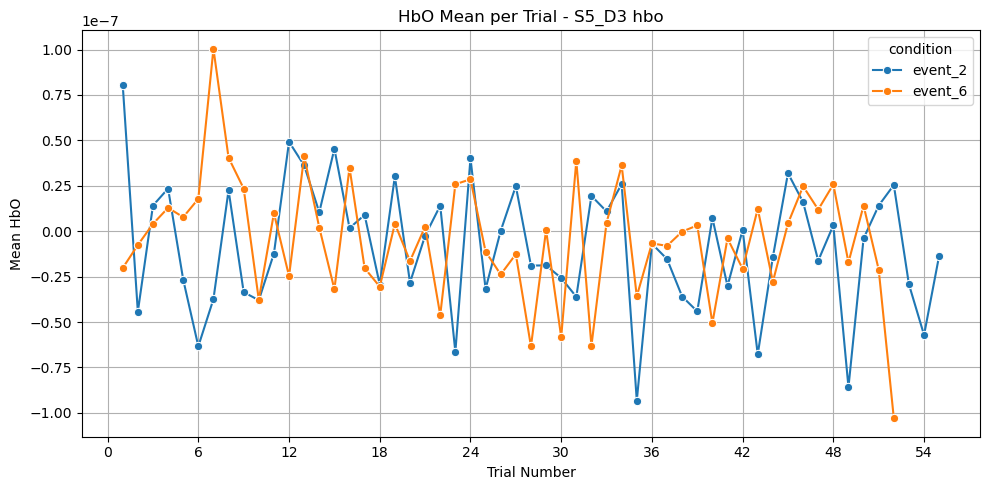

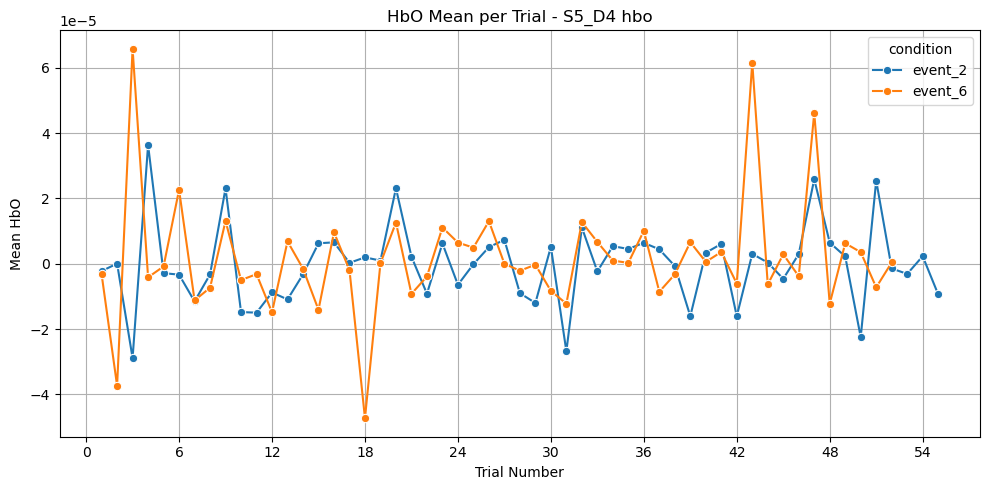

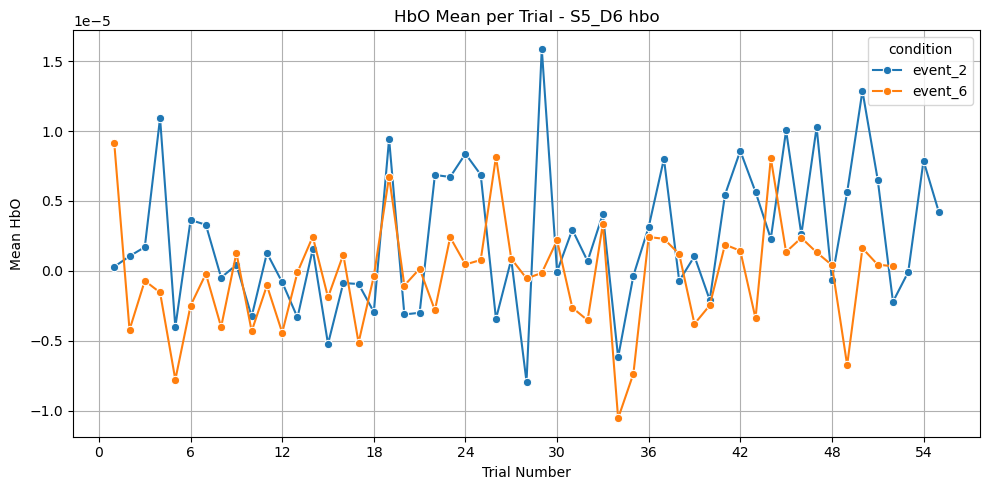

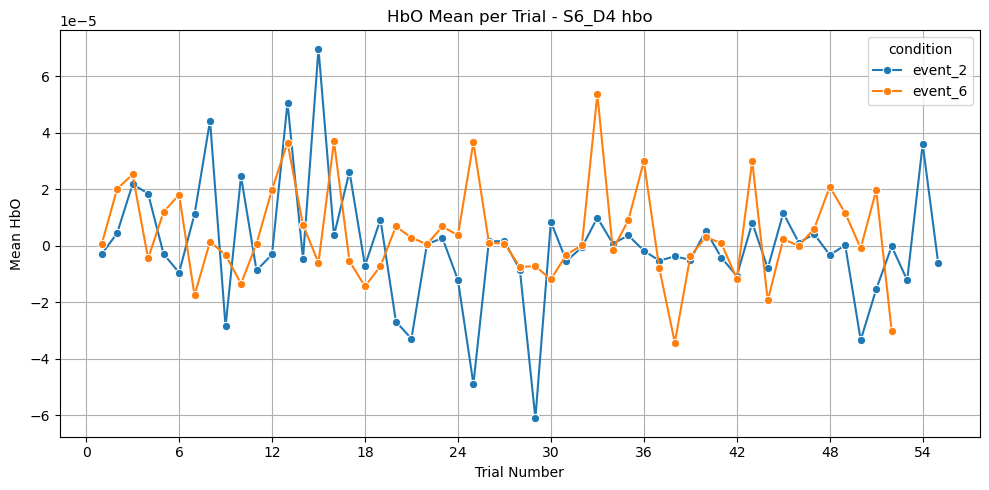

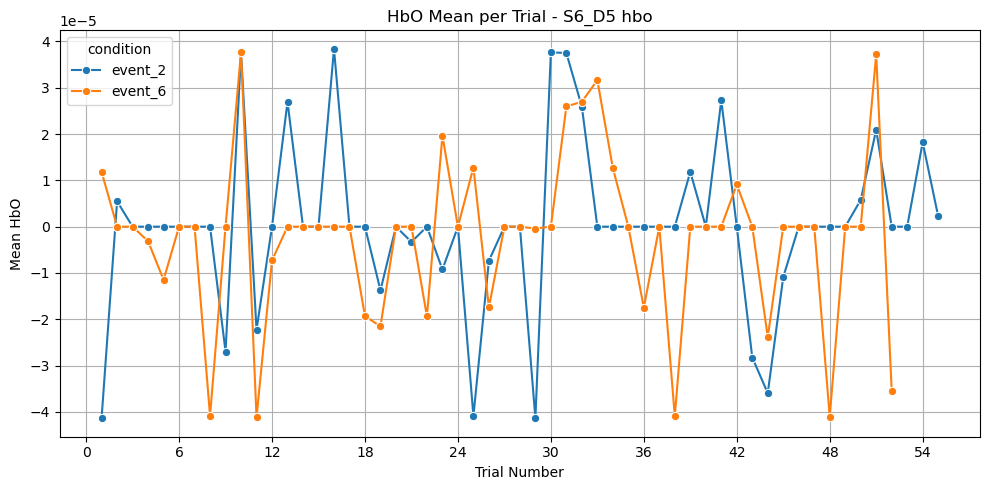

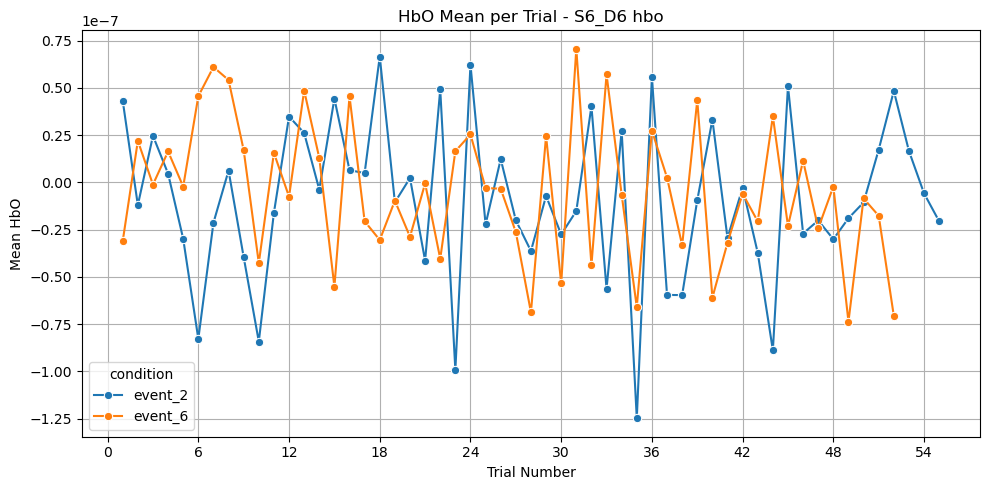

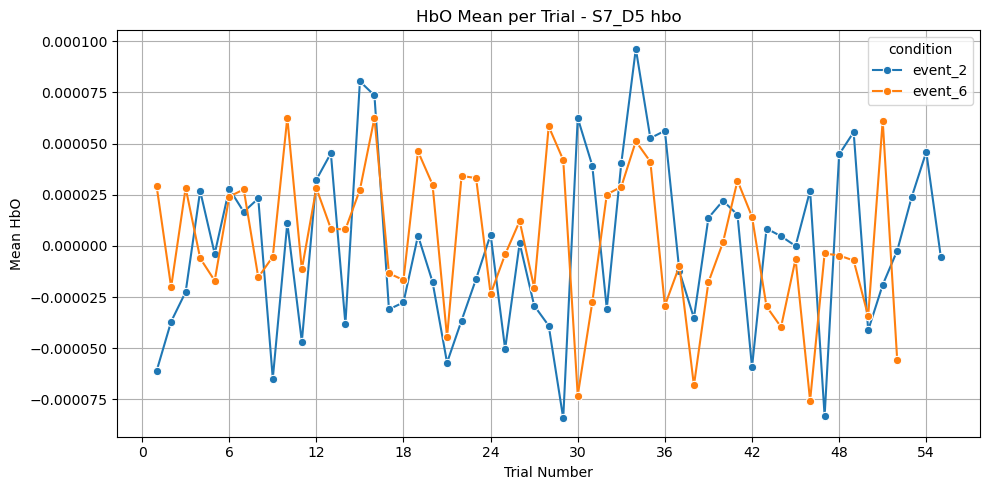

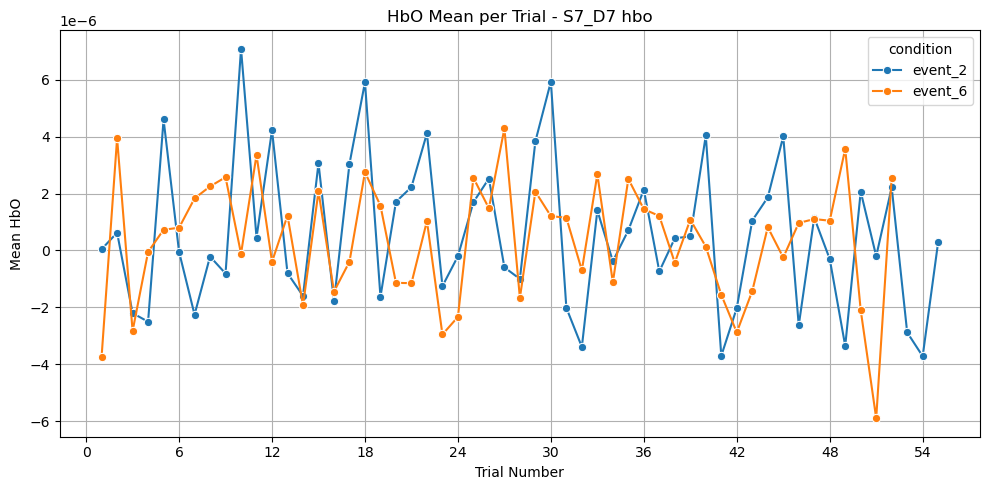

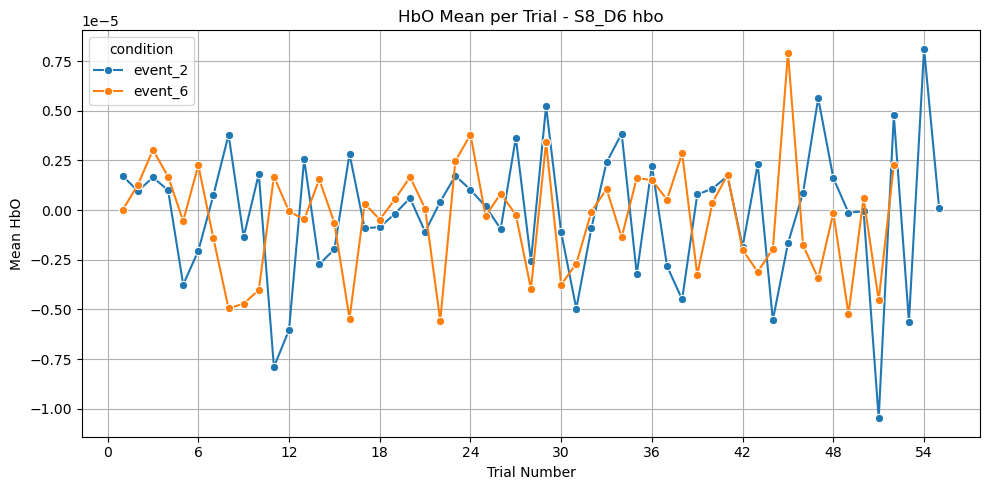

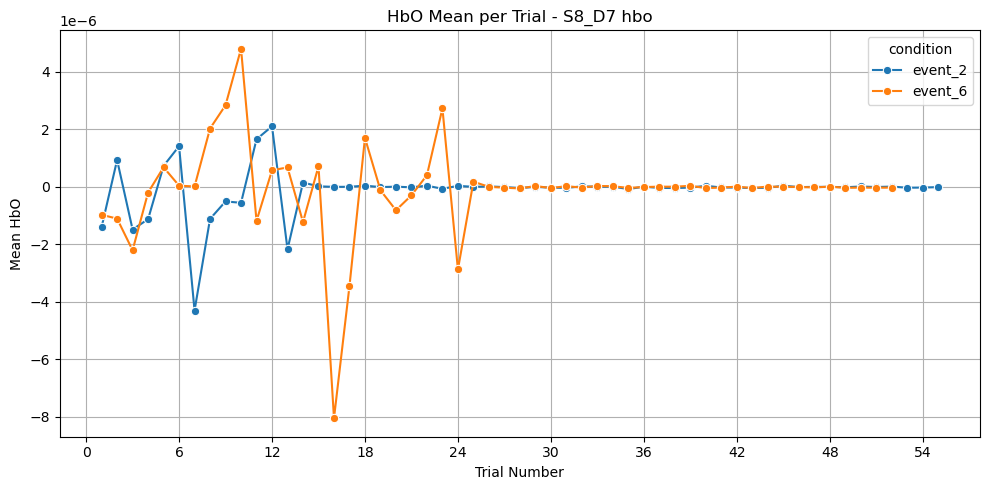

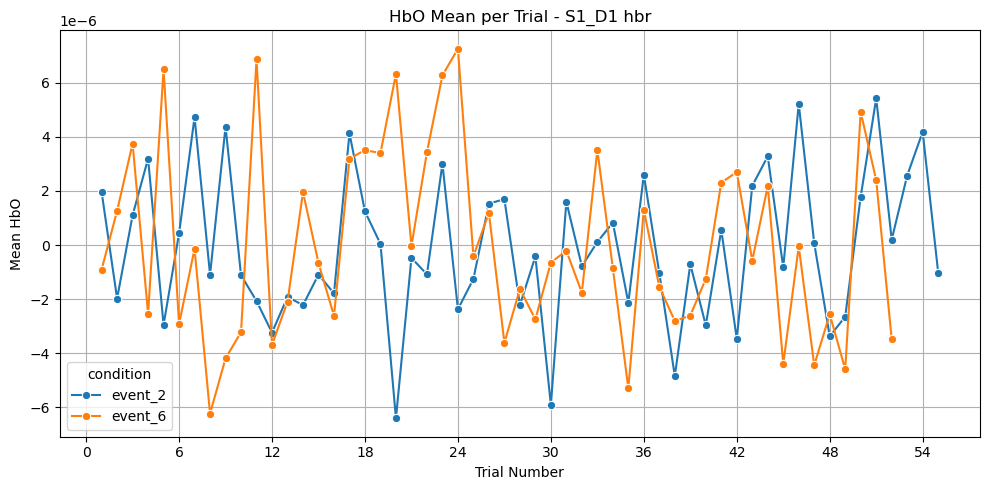

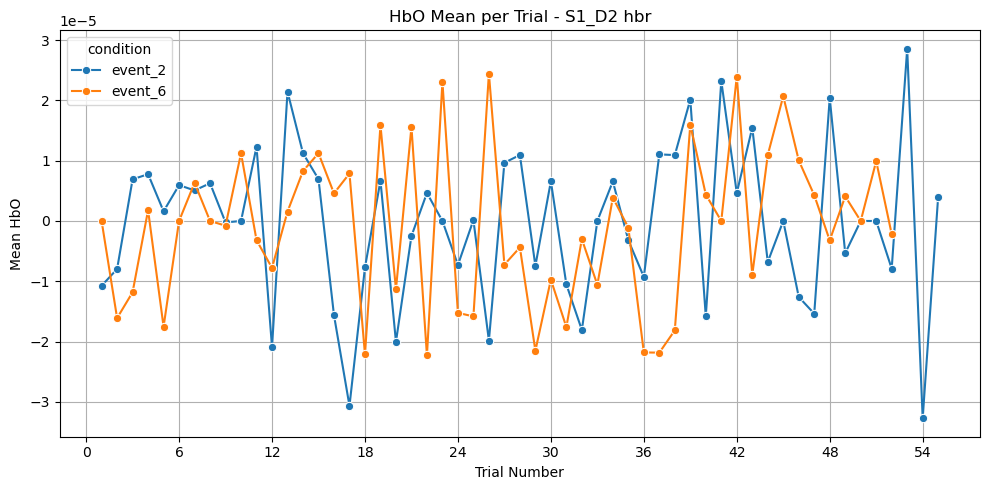

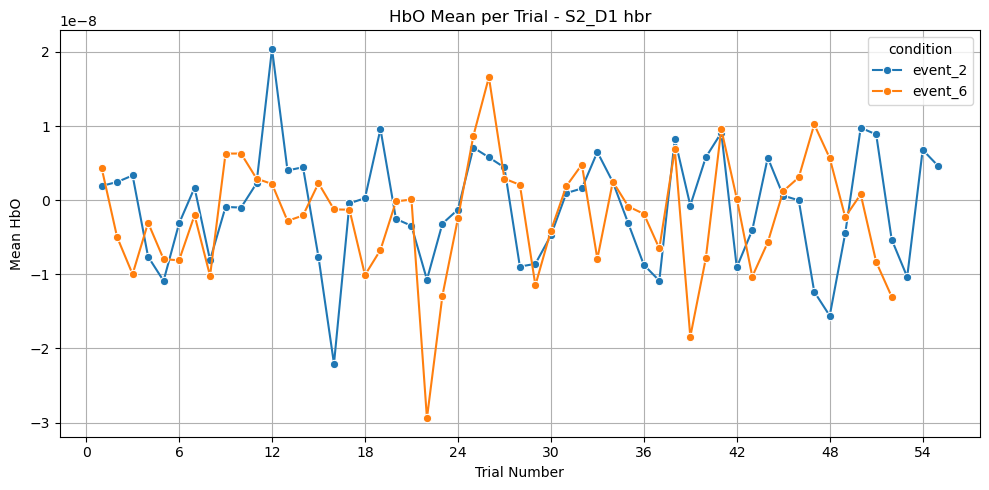

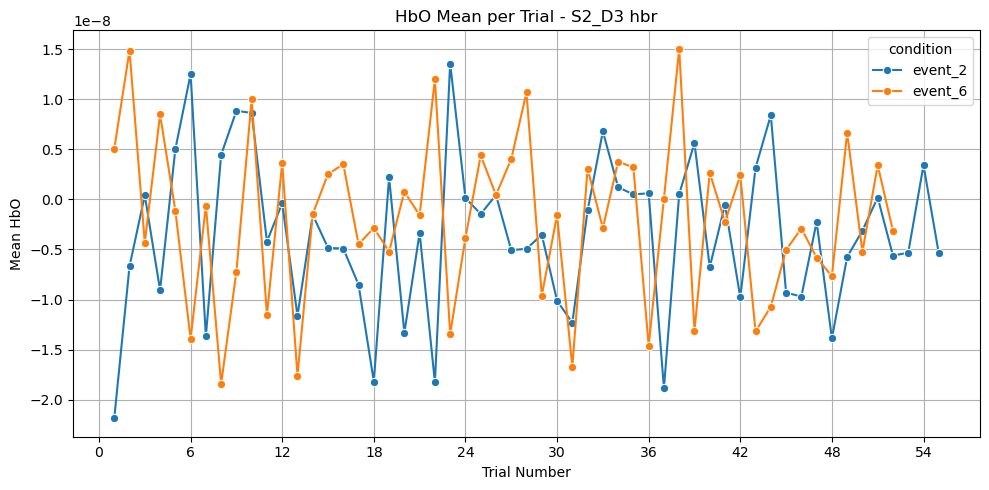

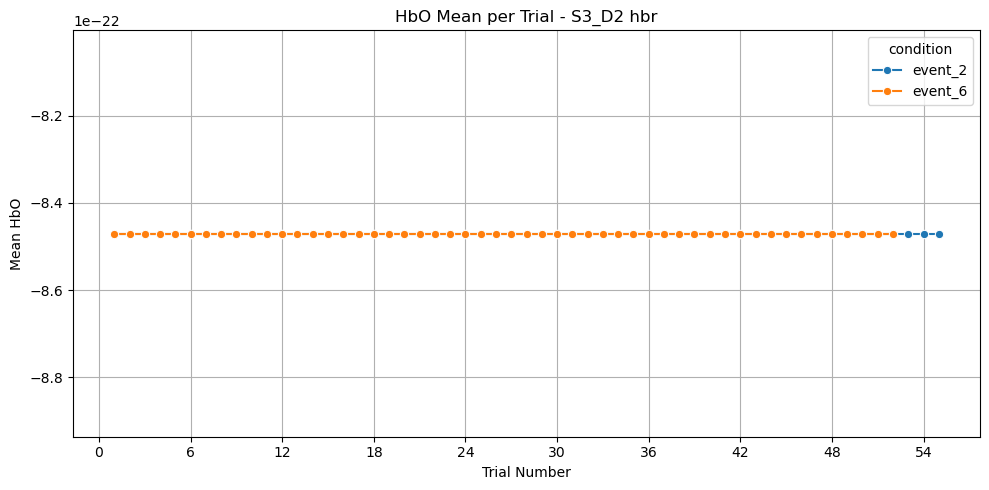

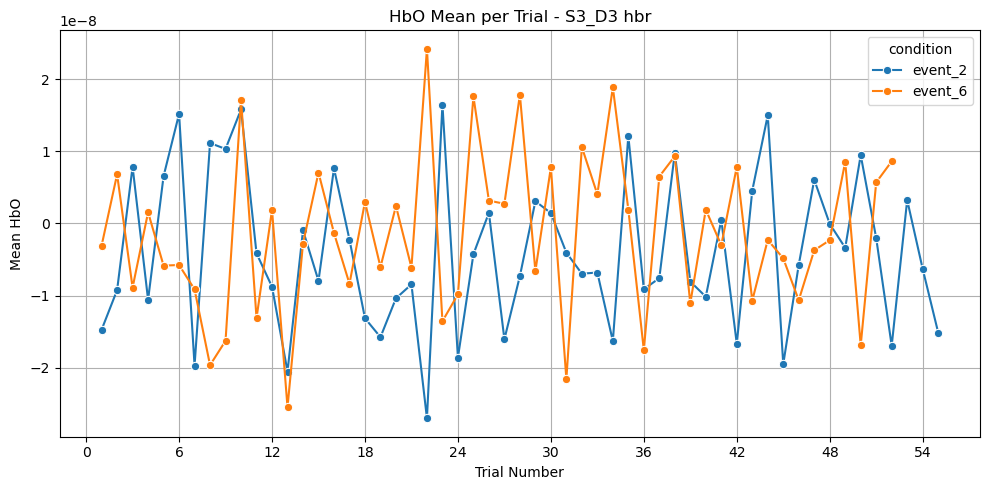

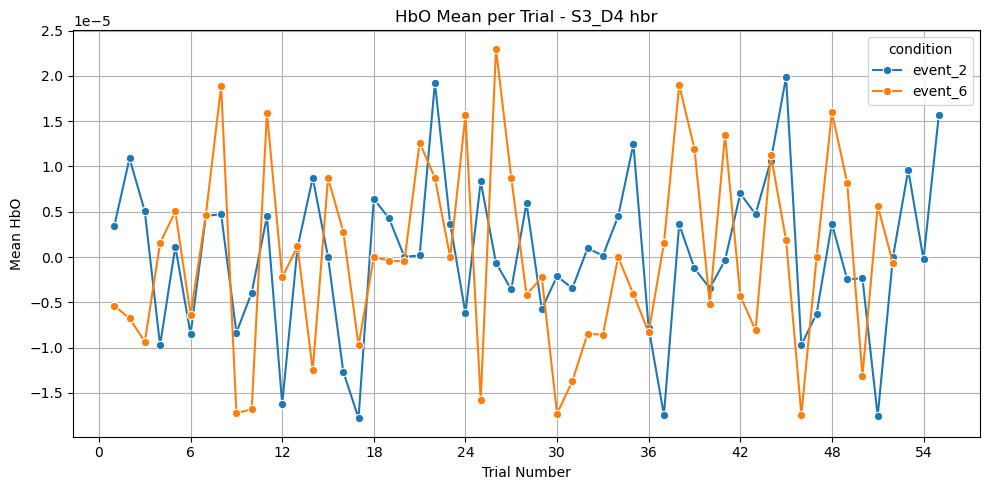

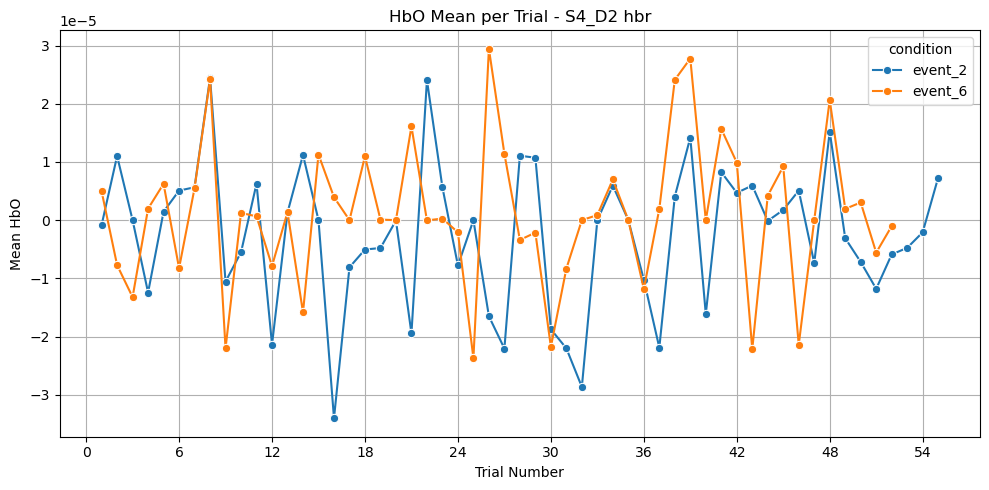

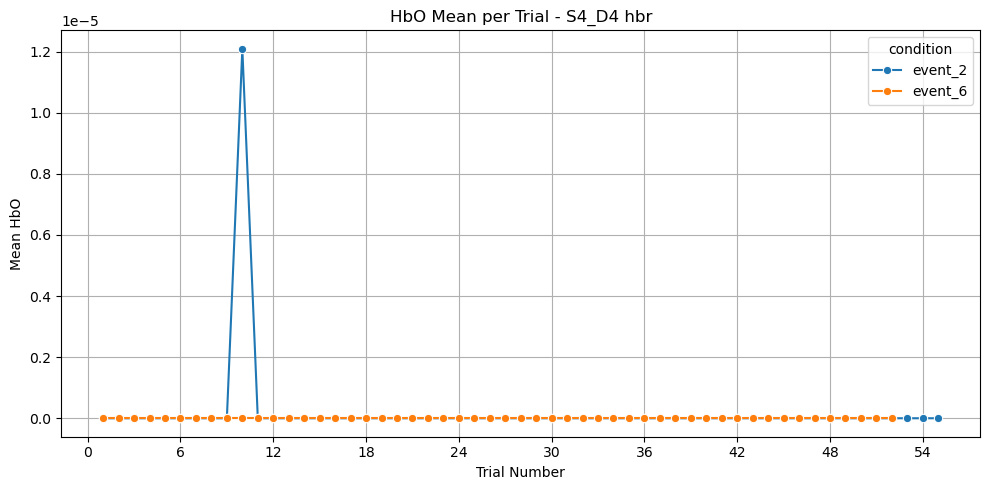

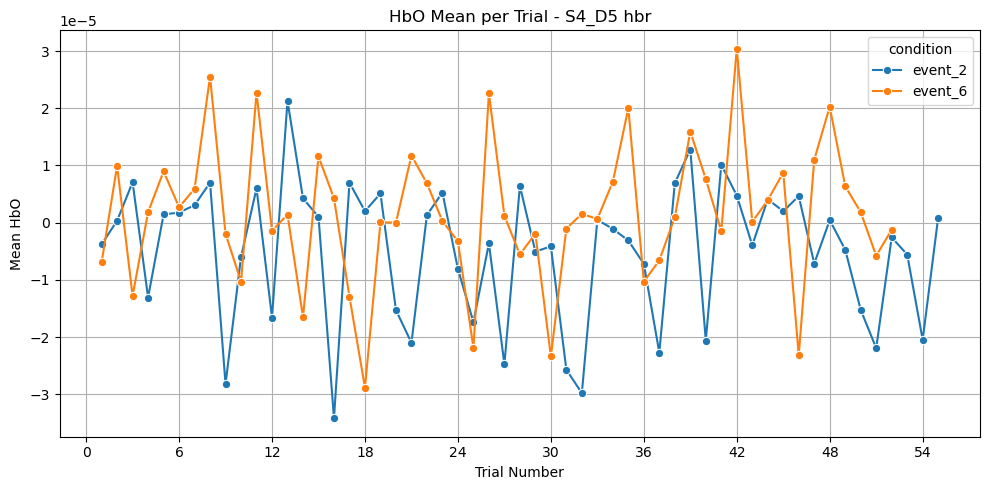

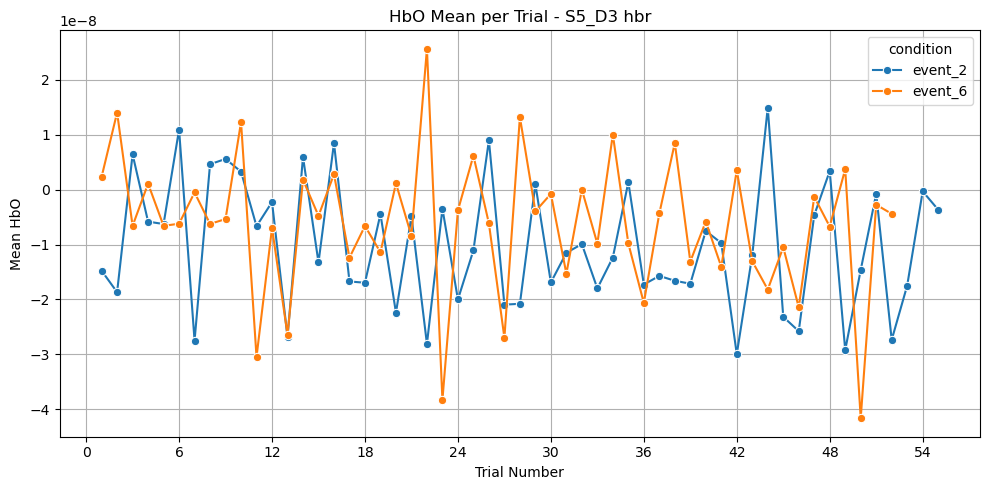

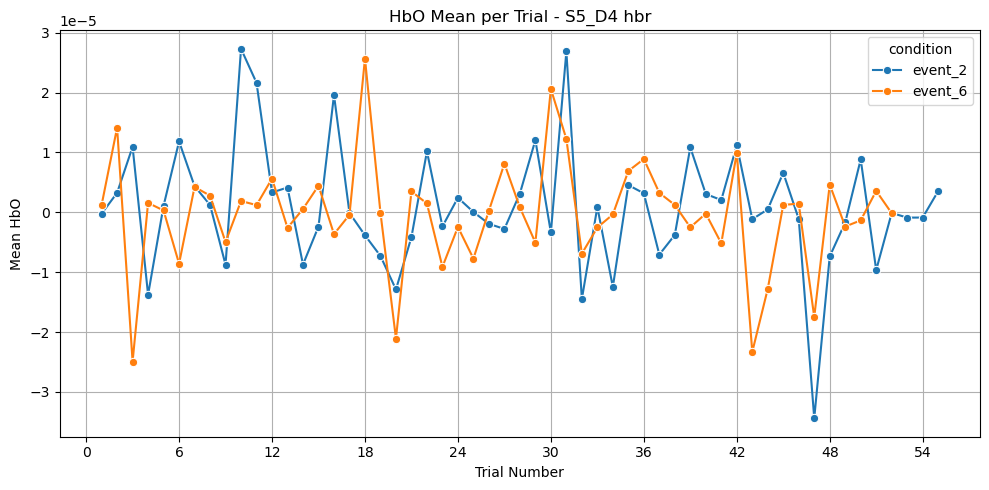

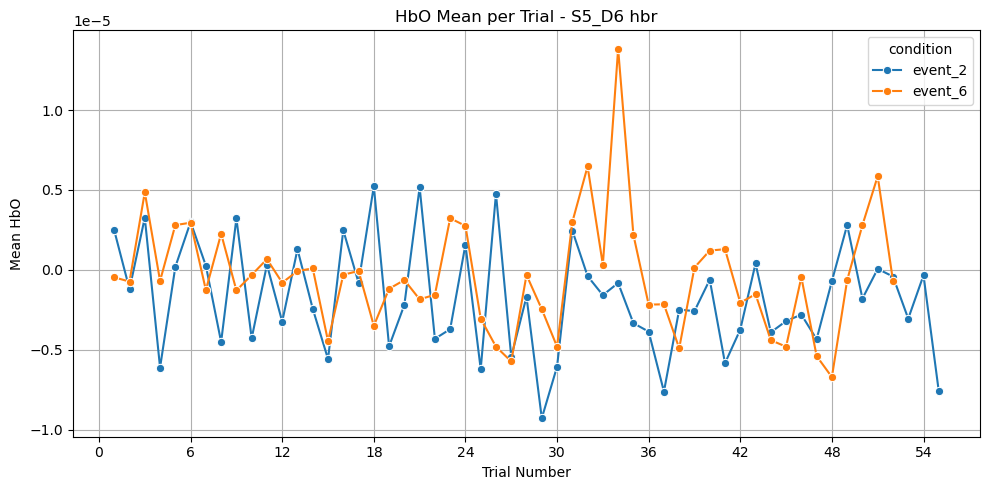

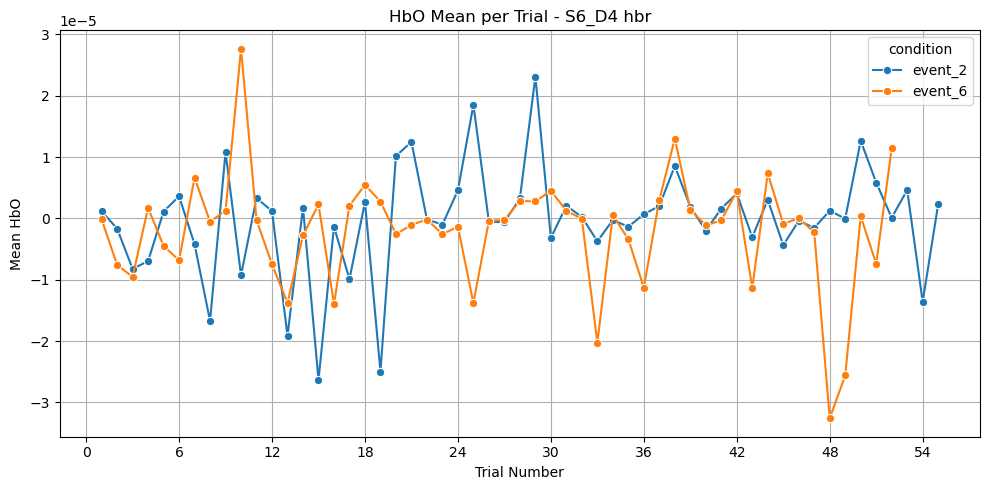

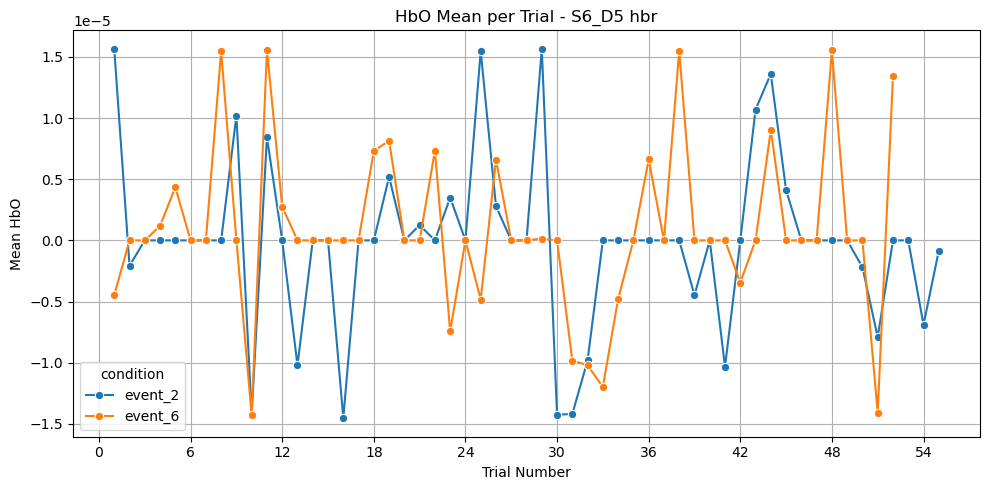

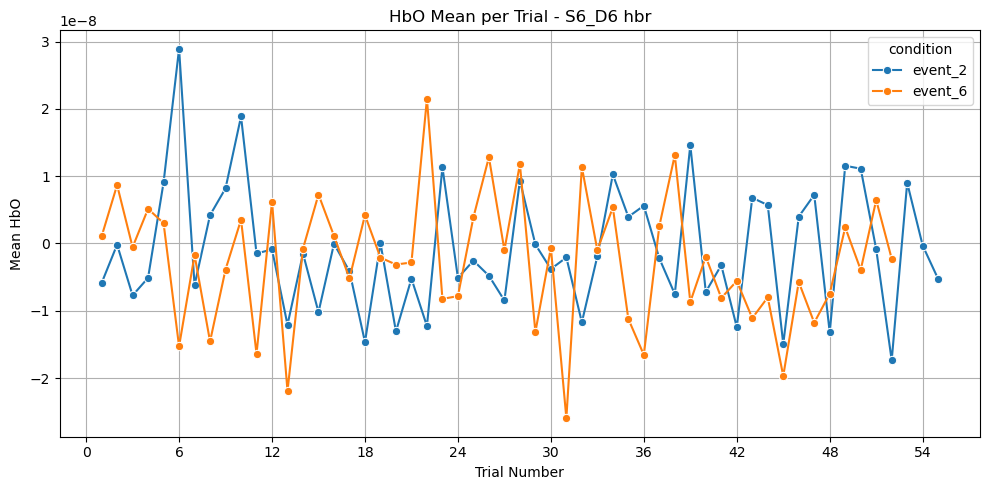

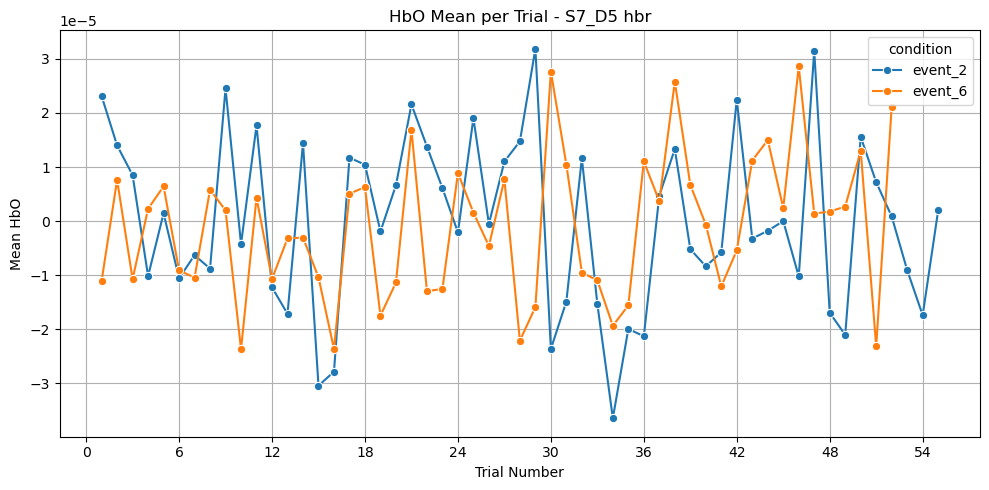

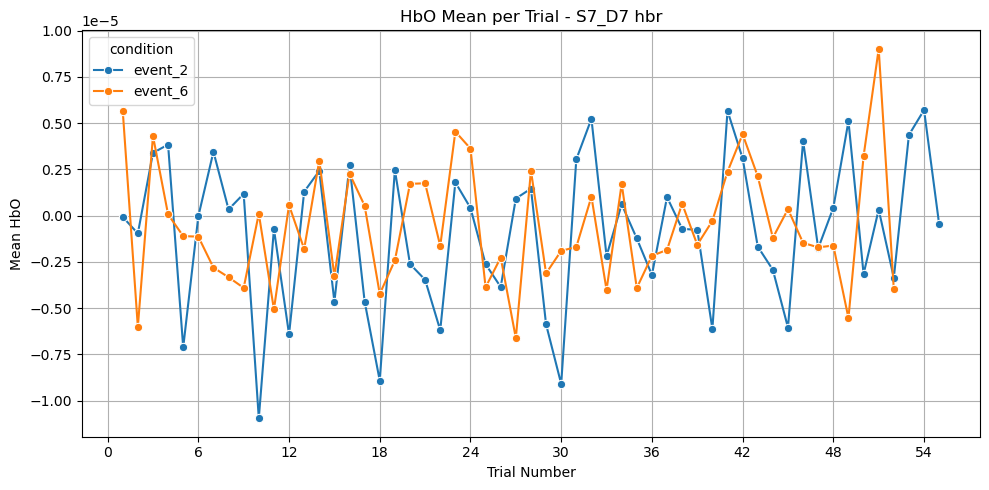

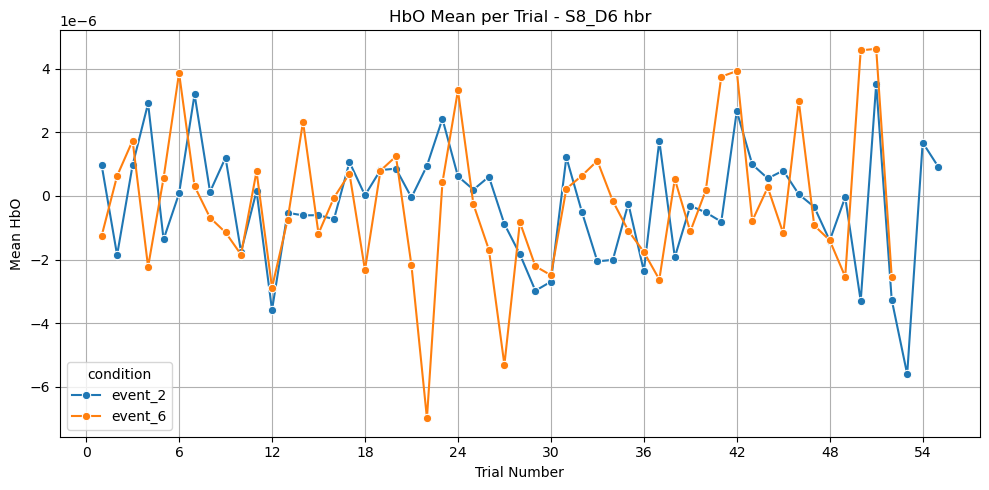

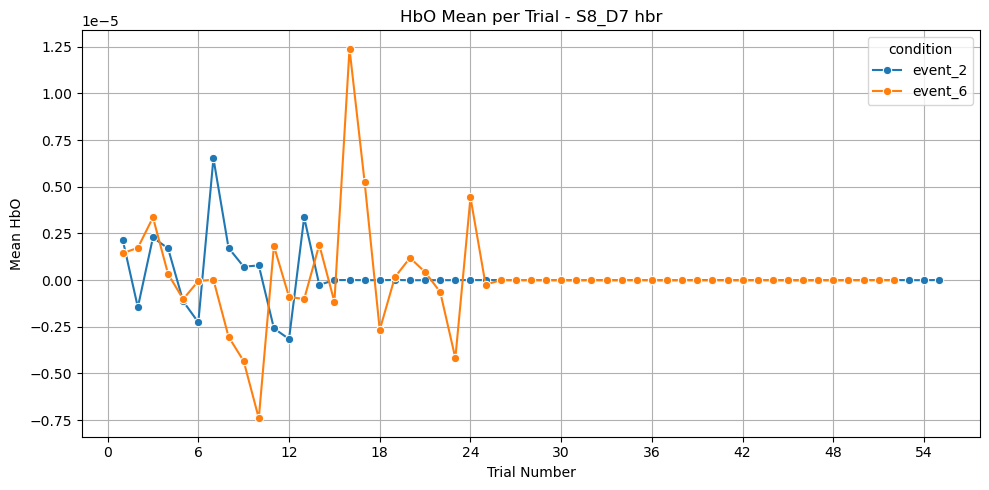

In [ ]:
# 채널별 평균 HbO 값을 trial마다 저장
df_list = []

for cond in ['event_2', 'event_6']:
    this_epochs = epochs[cond]
    for i, epoch in enumerate(this_epochs):
        mean_hbo = epoch.mean(axis=1)  # (n_channels,)
        for ch_name, val in zip(this_epochs.ch_names, mean_hbo):
            df_list.append({
                'condition': cond,
                'trial': i + 1,
                'channel': ch_name,
                'hbo_mean': val
            })

df_hbo = pd.DataFrame(df_list)

# 예: 채널별로 trial 순서에 따른 평균 HbO 변화 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

for ch in df_hbo['channel'].unique():
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_hbo[df_hbo['channel'] == ch], x='trial', y='hbo_mean', hue='condition', marker='o')
    plt.title(f'HbO Mean per Trial - {ch}')
    plt.xlabel('Trial Number')
    plt.ylabel('Mean HbO')
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()